# Code for experiments with colored MNIST and Celeba

## 1. Imports

In [1]:
import os
import sys
import logging

sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline 

import gc
import json
import warnings

import torch
import torch.nn as nn
import wandb
from IPython.display import clear_output

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
from tqdm import tqdm

LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)
warnings.filterwarnings("ignore")

In [2]:
gc.collect()
torch.cuda.empty_cache()

In [3]:
# 配置日志
logging.basicConfig(
    level=logging.INFO,
    filename='half_training.log',
    format='%(asctime)s - [line:%(lineno)d] - %(levelname)s: %(message)s',
    filemode='a'  # 这里的'w'代表写模式，如果用'a'，则为追加模式
)

# 获取日志器
logger = logging.getLogger()

logger.info("Logger init")

## 2. Config

Dataset choosing in the first rows

Continue training in the last rows

In [4]:
# For Celeba exps
# DATASET1, DATASET1_PATH = "CelebA_low", "/home/zyz/data/img_align_celeba"
# DATASET2, DATASET2_PATH = "CelebA_high", "/home/zyz/data/img_align_celeba"

# For Colored MNIST exps
DATASET1, DATASET1_PATH = "MNIST-colored_2", "/home/zyz/data/MNIST"
DATASET2, DATASET2_PATH = "MNIST-colored_3", "/home/zyz/data/MNIST"

SEED = 0xBADBEEF


# whether continue training first for choosing pivotal t network, last for choosing training iteration
CONTINUE = (-1, -1)

# We use epsilon in [0, 1, 10]
EPSILON = 1

# N steps in the Euler-Maruyama(step number of SDE shift and noise)
N_STEPS = 10
BATCH_SIZE = 64
COST = "schrodinger"

MAX_STEPS = 150001 # MAX_STEPS = 100001
INNER_ITERS = 10

# GPU choosing
DEVICE_IDS = [0,1,2]

# the step number adding noise in diffusion process style
HALF_STEPS = 1000  
PIVOTAL_LIST = [0, 50, 100]

LOG_INTERVAL = 100
PLOT_INTERVAL = 500
CPKT_INTERVAL = 500

# All hyperparameters below is set to the values used for the experiments, which discribed in the article
BETA_NET_LR, SDE_LR = 1e-4, 1e-4
BETA_BETA_NET, BETA_SDE = 0.9, 0.9
SDE_GRADIENT_MAX_NORM = float("inf")
BETA_NET_GRADIENT_MAX_NORM = float("inf")


IMG_SIZE = 32
UNET_BASE_FACTOR = 128

TIME_DIM = 128
CONSTANT_TIME = False
USE_POSITIONAL_ENCODING = True
RESNET_GENERATOR = False
INTEGRAL_SCALE = 1 / (3 * IMG_SIZE * IMG_SIZE)
ONE_STEP_INIT_ITERS = 0

PREDICT_SHIFT = True
SMART_INTERVALS = False
INTERVAL_SHRINK_START_TIME = 0.98
LAST_STEP_NOISE_STD = 1e-3
USE_GRADIENT_CHECKPOINT = False
PREDICT_NOISE_AT_LAST_STEP = False
N_LAST_STEPS_WITHOUT_NOISE = 1
TRACK_VAR_INTERVAL = 10
IMPROVED_DIFFUSION = False
USE_CHECKPOINTS_INSIDE_MODEL = False
EPSILON_SCHEDULER_LAST_ITER = 20000
USE_EXPONENTIAL_AVERAGE_MODEL = False
DISTINCT_SHIFT_MODELS = False
IMAGE_INPUT = True

DATASET1_CHANNELS = 3
DATASET2_CHANNELS = 3
GRAY_PLOTS = False
STEPS_TO_SHOW = 10


GAMMA0, GAMMA1 = 0.0, 0.333
GAMMA_ITERS = 20000

In [5]:
EXP_NAME = f"LAST_HALF_TEST"
OUTPUT_PATH = f"../our_checkpoints/{EXP_NAME}/"

logger.info(f"{EXP_NAME = }")

In [6]:
config = dict(
    SEED=SEED,
    DATASET1=DATASET1,
    DATASET2=DATASET2,
    INNER_ITERS=INNER_ITERS,
    HALF_STEPS=HALF_STEPS,
    BETA_NET_LR=BETA_NET_LR,
    SDE_LR=SDE_LR,
    PIVOTAL_LIST=PIVOTAL_LIST,
    BATCH_SIZE=BATCH_SIZE,
    UNET_BASE_FACTOR=UNET_BASE_FACTOR,
    N_STEPS=N_STEPS,
    EPSILON=EPSILON,
    CONSTANT_TIME=CONSTANT_TIME,
    USE_POSITIONAL_ENCODING=USE_POSITIONAL_ENCODING,
    TIME_DIM=TIME_DIM,
    RESNET_GENERATOR=RESNET_GENERATOR,
    INTEGRAL_SCALE=INTEGRAL_SCALE,
    ONE_STEP_INIT_ITERS=ONE_STEP_INIT_ITERS,
    SDE_GRADIENT_MAX_NORM=SDE_GRADIENT_MAX_NORM,
    BETA_NET_GRADIENT_MAX_NORM=BETA_NET_GRADIENT_MAX_NORM,
    PREDICT_SHIFT=PREDICT_SHIFT,
    SMART_INTERVALS=SMART_INTERVALS,
    INTERVAL_SHRINK_START_TIME=INTERVAL_SHRINK_START_TIME,
    LAST_STEP_NOISE_STD=LAST_STEP_NOISE_STD,
    USE_GRADIENT_CHECKPOINT=USE_GRADIENT_CHECKPOINT,
    PREDICT_NOISE_AT_LAST_STEP=PREDICT_NOISE_AT_LAST_STEP,
    N_LAST_STEPS_WITHOUT_NOISE=N_LAST_STEPS_WITHOUT_NOISE,
    LOG_INTERVALS=LOG_INTERVAL,
    TRACK_VAR_INTERVAL=TRACK_VAR_INTERVAL,
    IMPROVED_DIFFUSION=IMPROVED_DIFFUSION,
    USE_CHECKPOINTS_INSIDE_MODEL=USE_CHECKPOINTS_INSIDE_MODEL,
    EPSILON_SCHEDULER_LAST_ITER=EPSILON_SCHEDULER_LAST_ITER,
    USE_EXPONENTIAL_AVERAGE_MODEL=USE_EXPONENTIAL_AVERAGE_MODEL,
    DISTINCT_SHIFT_MODELS=DISTINCT_SHIFT_MODELS,
)

AUGMENTED_DATASETS = ["dtd"]
FID_EPOCHS = 50 if DATASET1 in AUGMENTED_DATASETS else 1

assert torch.cuda.is_available()
torch.cuda.set_device(f"cuda:{DEVICE_IDS[0]}")
torch.manual_seed(SEED)
np.random.seed(SEED)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

logger.info(f"EXP config: \n{config}")

## 3. Function definition

### network generator

In [7]:
from src.cunet import CUNet
from src.resnet2 import ResNet_D
from src.enot import SDE, integrate

### data and pivotal sampler

In [8]:
from diffusers import DDIMScheduler
from src import distributions

# TODO: 统一 batch_size 和 plot_n_samples

# 采样关键点
def sample_all_pivotal(
    source_sampler: distributions.Sampler,
    target_sampler: distributions.Sampler,
    batch_size: int = 64,
    half_steps: int = 1000,
    pivotal_list: list[int] = [0, 20, 50, 100],
) -> list[torch.Tensor]:
    scheduler = DDIMScheduler(num_train_timesteps=half_steps)
    pivotal_path = []

    source: torch.Tensor = source_sampler.sample(batch_size)
    target: torch.Tensor = target_sampler.sample(batch_size)
    source_list = [source]
    target_list = [target]
    for i in range(min(half_steps, pivotal_list[-1])):
        source = scheduler.add_noise(
            source, torch.randn_like(source), torch.Tensor([i]).long()
        )
        target = scheduler.add_noise(
            target, torch.randn_like(target), torch.Tensor([i]).long()
        )
        if (i + 1) in pivotal_list:
            source_list.append(source)
            target_list.append(target)

    target_list.reverse()

    pivotal_path.extend(source_list)
    pivotal_path.extend(target_list[1:])

    return pivotal_path


def sample_step_t_pivotal(
    source_sampler: distributions.Sampler,
    target_sampler: distributions.Sampler,
    batch_size: int = 64,
    half_steps: int = 1000,
    pivotal_list: list[int] = [0, 200, 500, 1000],
    pivotal_step: int = 0,
):
    pivotal_path = sample_all_pivotal(
        source_sampler, target_sampler, batch_size, half_steps, pivotal_list
    )
    pivotal_t, pivotal_tadd1 = (
        pivotal_path[pivotal_step],
        pivotal_path[pivotal_step + 1],
    )
    return pivotal_t, pivotal_tadd1

### mapping plotters

In [9]:
from copy import deepcopy
from numpy import ndarray
from src.plotters import (
    plot_fixed_sde_images,
    plot_fixed_sde_trajectories,
    plot_random_sde_images,
    plot_random_sde_trajectories,
    plot_several_fixed_sde_trajectories,
    plot_several_random_sde_trajectories,
)
from src.tools import fig2img


def draw_all_pivotal(
    source: torch.Tensor,
    target: torch.Tensor,
    half_steps: int = 1000,
    pivotal_list: list[int] = [0, 20, 50, 100],
) -> list:
    scheduler = DDIMScheduler(num_train_timesteps=half_steps)
    pivotal_path = []

    source_list = [source]
    target_list = [target]
    for i in range(min(half_steps, pivotal_list[-1])):
        source = scheduler.add_noise(
            source, torch.randn_like(source), torch.Tensor([i]).long()
        )
        target = scheduler.add_noise(
            target, torch.randn_like(target), torch.Tensor([i]).long()
        )
        if (i + 1) in pivotal_list:
            source_list.append(source)
            target_list.append(target)

    target_list.reverse()

    pivotal_path.extend(source_list)
    pivotal_path.extend(target_list[1:])
    print(f"[Debug] {len(pivotal_path) = }")
    imgs: ndarray = (
        torch.stack(pivotal_path)
        .to("cpu")
        .permute(0, 2, 3, 1)
        .mul(0.5)
        .add(0.5)
        .numpy()
        .clip(0, 1)
    )
    nrows, ncols = 1, len(pivotal_path)
    print(f"[Debug] {imgs.shape = } {len(pivotal_path) = }")
    fig, axes = plt.subplots(nrows, ncols, figsize=(11 * ncols, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(imgs[i])
        ax.get_yaxis().set_visible(False)
        ax.set_yticks([])

    axes[0].set_xlabel("Source", fontsize=24)
    for i in range(1, ncols - 1):
        axes[i].set_xlabel(f"Sub mapping {i - 1}", fontsize=24)
    axes[-1].set_xlabel("Target", fontsize=24)

    torch.cuda.empty_cache()
    gc.collect()


@torch.no_grad()
def draw_sub_mapping(
    source_sampler: distributions.Sampler,
    target_sampler: distributions.Sampler,
    sde: SDE,
    plot_n_samples: int = 4,
    half_steps: int = 1000,
    pivotal_list: list[int] = [0, 200, 500, 1000],
    pivotal_step: int = 0,
    saving_path: str | None = None,
):
    clear_output()
    source, target = sample_step_t_pivotal(
        source_sampler,
        target_sampler,
        plot_n_samples,
        half_steps,
        pivotal_list,
        pivotal_step=pivotal_step,
    )

    tr, _, _ = sde(source)
    mapped = tr[:, -1, :]

    imgs: ndarray = (
        torch.stack([source, target, mapped])
        .to("cpu")
        .permute(1, 0, 3, 4, 2)
        .mul(0.5)
        .add(0.5)
        .numpy()
        .clip(0, 1)
    )  # shpae = (plot_n_samples, 3, (RGB image))
    fig, axes = plt.subplots(nrows=plot_n_samples, ncols=3)
    for i in range(plot_n_samples):
        axes[i][0].imshow(imgs[i][0])
        axes[i][1].imshow(imgs[i][1])
        axes[i][2].imshow(imgs[i][2])

        axes[i][0].set_axis_off()
        axes[i][1].set_axis_off()
        axes[i][2].set_axis_off()

    fig.tight_layout(pad=0.001)
    if saving_path:
        plt.savefig(os.path(saving_path))
    plt.show()

    torch.cuda.empty_cache()
    gc.collect()

    return fig, axes


# @torch.no_grad()
# def draw_linked_mapping(
#     plot_n_samples,
#     source_sampler,
#     target_sampler,
#     batch_size,
#     half_steps,
#     pivotal_list,
#     SDEs: list[torch.nn.Module],
#     img_path: None,
# ):
#     device = next(SDEs[0].parameters()).device
#     source_dataset, target_dataset, mapped_dataset = [], [], []
#     for i in range(plot_n_samples // batch_size + 1):
#         all_pivotal = sample_all_pivotal(
#             source_sampler, target_sampler, batch_size, half_steps, pivotal_list
#         )
#         source, target = all_pivotal[0].to(device), all_pivotal[-1].to(device)

#         # TODO: 可视化 linked mapping 中的所有 pivotal
#         pivotals = [source.clone().detach()]
#         for t in range(len(SDEs)):
#             x0 = pivotals[t]
#             trajectory, times, _ = SDEs[t](x0)
#             xN = trajectory[:, -1, :]
#             pivotals.append(xN)

#         mapped_dataset.append(pivotals[-1])
#         source_dataset.append(source)
#         target_dataset.append(target)

#     source_dataset, target_dataset, mapped_dataset = (
#         torch.cat(source_dataset[:plot_n_samples]).cpu(),
#         torch.cat(target_dataset[:plot_n_samples]).cpu(),
#         torch.cat(mapped_dataset[:plot_n_samples]).cpu(),
#     )

#     plot_results(source_dataset, target_dataset, mapped_dataset)
#     if img_path:
#         plt.savefig(img_path)
#     plt.show()

### trainer

In [10]:
from src.tools import (
    fig2img,  # for wandb
    freeze,
    get_sde_pushed_loader_stats,
    unfreeze,
    weights_init_D,
)
from src.fid_score import calculate_frechet_distance


def epsilon_scheduler(step):
    return min(EPSILON, EPSILON * (step / EPSILON_SCHEDULER_LAST_ITER))


# submapping training
def training_sub_mapping(
    source_sampler: distributions.Sampler,
    target_sampler: distributions.Sampler,
    sde: SDE | torch.nn.DataParallel | torch.nn.Module,
    beta_net: ResNet_D | torch.nn.Module | torch.nn.Module,
    sde_opt: torch.optim.Optimizer,
    beta_net_opt: torch.optim.Optimizer,
    sde_scheduler: torch.optim.lr_scheduler,
    beta_net_scheduler: torch.optim.lr_scheduler,
    iterations: int = 1000,
    inner_iterations: int = 10,
    half_steps: int = 1000,
    pivotal_list: list[int] = [0, 200, 500, 1000],
    batch_size: int = 128,
    pivotal_step: int = 0,
    saving_path: str | None = None,
):
    start = 0
    if CONTINUE[1] != -1:
        start = CONTINUE[1] + 1
    for iter in tqdm(range(start, iterations)):
        # TODO: Interval actions
        if iter % LOG_INTERVAL == 0:
            logger.info(f"training sde at iteration {iter}")
        if iter % PLOT_INTERVAL == 0:
            draw_sub_mapping(
                source_sampler,
                target_sampler,
                sde,
                4,
                half_steps,
                pivotal_list,
                pivotal_step,
            )
        if iter % CPKT_INTERVAL == 0:
            pass
        # Optim beta network
        freeze(sde)
        unfreeze(beta_net)
        beta_net.train()
        beta_net_opt.zero_grad()
        source, target = sample_step_t_pivotal(
            source_sampler,
            target_sampler,
            batch_size,
            half_steps,
            pivotal_list,
            pivotal_step,
        )
        source.requires_grad_()
        # forward
        trajectory, times, shifts = sde(source)
        target_predicted = trajectory[:, -1]
        # loss
        norm = torch.norm(shifts.flatten(start_dim=2), p=2, dim=-1) ** 2
        integral = INTEGRAL_SCALE * integrate(norm, times[0])
        loss_beta = (-integral - beta_net(target) + beta_net(target_predicted)).mean()
        beta_net_grad_norm = torch.nn.utils.clip_grad_norm_(
            beta_net.parameters(), max_norm=BETA_NET_GRADIENT_MAX_NORM
        )
        # backward and update weights
        beta_net_opt.step()
        # update beta network lr scheduler
        beta_net_scheduler.step()
        # clear memory cache
        del loss_beta, source, target, target_predicted
        gc.collect()
        torch.cuda.empty_cache()

        # Optim sde network
        freeze(beta_net)
        unfreeze(sde)
        sde.train()
        new_epsilon = epsilon_scheduler(iter)
        if len(DEVICE_IDS) > 1:
            sde.module.set_epsilon(new_epsilon)
        else:
            sde.set_epsilon(new_epsilon)

        for in_iter in range(inner_iterations):
            sde_opt.zero_grad()
            source, target = sample_step_t_pivotal(
                source_sampler,
                target_sampler,
                batch_size,
                half_steps,
                pivotal_list,
                pivotal_step,
            )
            source.requires_grad_()
            # forward
            trajectory, times, shifts = sde(source)
            target_predicted = trajectory[:, -1]
            # loss
            norm = torch.norm(shifts.flatten(start_dim=2), p=2, dim=-1) ** 2
            integral = INTEGRAL_SCALE * integrate(norm, times[0])
            loss_sde = (integral + beta_net(target) - beta_net(target_predicted)).mean()
            # backward and update weights
            loss_sde.backward()
            sde_gradient_norm = torch.nn.utils.clip_grad_norm_(
                sde.parameters(), max_norm=SDE_GRADIENT_MAX_NORM
            )
            sde_opt.step()
        # update sde network lr scheduler
        sde_scheduler.step()
        # clear memory cache
        del loss_sde, source, target, target_predicted
        gc.collect()
        torch.cuda.empty_cache()


# linked mapping training
def training_linked_mapping(
    source_sampler: distributions.Sampler,
    target_sampler: distributions.Sampler,
    SDEs: list[SDE | torch.nn.DataParallel | torch.nn.Module],
    BETA_NETs: list[ResNet_D | torch.nn.Module | torch.nn.Module],
    SDE_OPTs: list[torch.optim.Optimizer],
    BETA_NET_OPTs: list[torch.optim.Optimizer],
    SDE_SCHEDULERs: list[torch.optim.lr_scheduler.LRScheduler],
    BETA_NET_SCHEDULERs: list[torch.optim.lr_scheduler.LRScheduler],
    iterations: int = 1000,
    inner_iterations: int = 10,
    half_steps: int = 1000,
    pivotal_list: list[int] = [0, 200, 500, 1000],
    batch_size: int = 128,
):
    start = len(SDEs) // 2    # setting just training last half mapping
    if CONTINUE[0] != -1:
        start = CONTINUE[0] + 1
    for t in range(start, len(SDEs)):
        logger.info(f"Start training {t}-th sde")
        # get t-th sde, beta_net, ...
        sde, sde_opt, sde_scheduler = SDEs[t], SDE_OPTs[t], SDE_SCHEDULERs[t]
        beta_net, beta_net_opt, beta_net_scheduler = (
            BETA_NETs[t],
            BETA_NET_OPTs[t],
            BETA_NET_SCHEDULERs[t],
        )

        # sub mapping training
        training_sub_mapping(
            source_sampler,
            target_sampler,
            sde,
            beta_net,
            sde_opt,
            beta_net_opt,
            sde_scheduler,
            beta_net_scheduler,
            iterations,
            inner_iterations,
            half_steps,
            pivotal_list,
            batch_size,
            pivotal_step=t,
        )

    # TODO: draw trained linked mapping

## 4. Train

### initalize data sampler

In [11]:
from src.tools import load_dataset


X_sampler, X_test_sampler = load_dataset(
    DATASET1, DATASET1_PATH, img_size=IMG_SIZE, batch_size=BATCH_SIZE, num_workers=8
)
Y_sampler, Y_test_sampler = load_dataset(
    DATASET2, DATASET2_PATH, img_size=IMG_SIZE, batch_size=BATCH_SIZE, num_workers=8
)

torch.cuda.empty_cache()
gc.collect()
clear_output()

logger.info("Data sampler OK")

### separate fixed X, Y, show sampler data and pivotal

[Debug] len(pivotal_path) = 5
[Debug] imgs.shape = (5, 32, 32, 3) len(pivotal_path) = 5


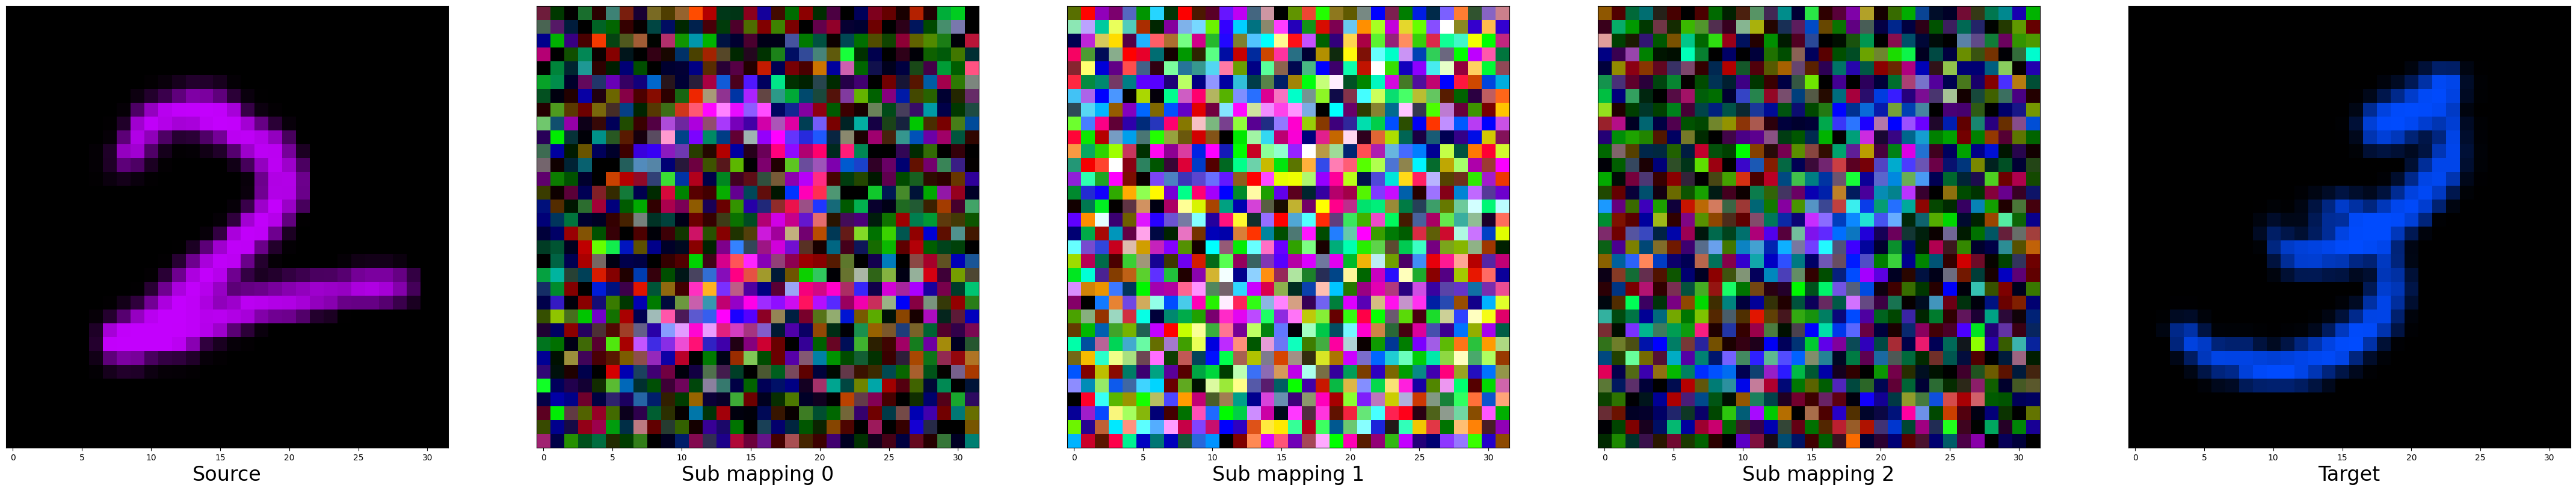

In [12]:
X_fixed, Y_fixed = X_sampler.sample(10), Y_sampler.sample(10)

X_test_fixed, Y_test_fixed = X_test_sampler.sample(10), Y_test_sampler.sample(10)

draw_all_pivotal(X_fixed[0], Y_fixed[0], HALF_STEPS, PIVOTAL_LIST)

### initialize model

In [13]:
SDEs, BETA_NETs = [], []
SDE_OPTs, BETA_NET_OPTs = [], []
SDE_SCHEDULERs, BETA_NET_SCHEDULERs = [], []

for i in range(len(PIVOTAL_LIST) * 2 - 2):
    sde = CUNet(
        DATASET1_CHANNELS, DATASET2_CHANNELS, TIME_DIM, base_factor=UNET_BASE_FACTOR
    ).cuda()

    sde = SDE(
        shift_model=sde,
        epsilon=EPSILON,
        n_steps=N_STEPS,
        time_dim=TIME_DIM,
        n_last_steps_without_noise=N_LAST_STEPS_WITHOUT_NOISE,
        use_positional_encoding=USE_POSITIONAL_ENCODING,
        use_gradient_checkpoint=USE_GRADIENT_CHECKPOINT,
        predict_shift=PREDICT_SHIFT,
        image_input=IMAGE_INPUT,
    ).cuda()
    SDEs.append(sde)

    beta_net = ResNet_D(IMG_SIZE, nc=DATASET2_CHANNELS).cuda()
    beta_net.apply(weights_init_D)
    BETA_NETs.append(beta_net)

    sde_opt = torch.optim.Adam(
        sde.parameters(), lr=SDE_LR, weight_decay=1e-10, betas=(BETA_SDE, 0.999)
    )
    beta_net_opt = torch.optim.Adam(
        beta_net.parameters(),
        lr=BETA_NET_LR,
        weight_decay=1e-10,
        betas=(BETA_BETA_NET, 0.999),
    )
    SDE_OPTs.append(sde_opt)
    BETA_NET_OPTs.append(beta_net_opt)

    sde_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        sde_opt, milestones=[15000, 25000, 40000, 55000, 70000], gamma=0.5
    )
    beta_net_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        beta_net_opt, milestones=[15000, 25000, 40000, 55000, 70000], gamma=0.5
    )
    SDE_SCHEDULERs.append(sde_scheduler)
    BETA_NET_SCHEDULERs.append(beta_net_scheduler)


if len(DEVICE_IDS) > 1 and CONTINUE[0] == -1 and CONTINUE[1] == -1:
    for i in range(len(SDEs)):
        SDEs[i] = nn.DataParallel(SDEs[i], device_ids=DEVICE_IDS)
        BETA_NETs[i] = nn.DataParallel(BETA_NETs[i], device_ids=DEVICE_IDS)

        print("T params:", np.sum([np.prod(p.shape) for p in SDEs[0].parameters()]))
        print(
            "D params:", np.sum([np.prod(p.shape) for p in BETA_NETs[0].parameters()])
        )

logger.info("Network init OK")

T params: 69568131
D params: 13494209
T params: 69568131
D params: 13494209
T params: 69568131
D params: 13494209
T params: 69568131
D params: 13494209


### TODO: setting continue training

In [30]:
if CONTINUE[0] > -1 or CONTINUE[1] > -1:
    for i in range(len(SDEs)):
        sde, sde_opt, sde_scheduler = SDEs[i], SDE_OPTs[i], SDE_SCHEDULERs[i]
        beta_net, beta_net_opt, beta_net_scheduler = (
            BETA_NETs[i],
            BETA_NET_OPTs[i],
            BETA_NET_SCHEDULERs[i],
        )

        sde_opt.load_state_dict(
            torch.load(
                os.path.join(OUTPUT_PATH, f"T_opt_{SEED}_sub{i}_{CONTINUE[1]}.pt")
            )
        )
        sde_scheduler.load_state_dict(
            torch.load(
                os.path.join(OUTPUT_PATH, f"T_scheduler_{SEED}_sub{i}_{CONTINUE[1]}.pt")
            )
        )

        sde.load_state_dict(
            torch.load(os.path.join(OUTPUT_PATH, f"T_{SEED}_sub{i}_{CONTINUE[1]}.pt"))
        )
        beta_net.load_state_dict(
            torch.load(os.path.join(OUTPUT_PATH, f"D_{SEED}_sub{i}_{CONTINUE[1]}.pt"))
        )

        if len(DEVICE_IDS) > 1:
            SDEs[i] = nn.DataParallel(sde, device_ids=DEVICE_IDS)
            BETA_NETs[i] = nn.DataParallel(beta_net, device_ids=DEVICE_IDS)

        beta_net_opt.load_state_dict(
            torch.load(
                os.path.join(OUTPUT_PATH, f"D_opt_{SEED}_sub{i}_{CONTINUE[1]}.pt")
            )
        )
        beta_net_scheduler.load_state_dict(
            torch.load(
                os.path.join(OUTPUT_PATH, f"D_scheduler_{SEED}_sub{i}_{CONTINUE[1]}.pt")
            )
        )
    logger.info(f"Continue training at {CONTINUE[0]}-th sde iter{CONTINUE[1]} status load OK")

### init wandb

In [31]:
# wandb.init(name=EXP_NAME, config=config)

### training

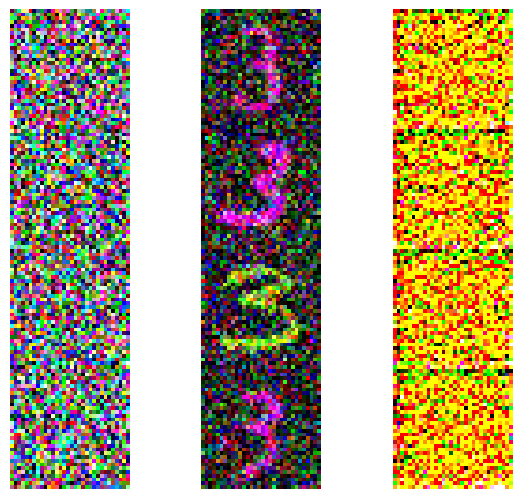

  0%|                                                                                                                                | 3/150001 [00:20<278:53:00,  6.69s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f265083e930>>
Traceback (most recent call last):
  File "/home/zyz/ENOT/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
  0%|                                                                                                                                | 4/150001 [00:27<282:17:41,  6.78s/it]


RuntimeError: DataLoader worker (pid(s) 101328, 101389, 101454, 101517, 101580, 101643, 101706, 101770) exited unexpectedly

In [14]:
training_linked_mapping(
    X_sampler,
    Y_sampler,
    SDEs,
    BETA_NETs,
    SDE_OPTs,
    BETA_NET_OPTs,
    SDE_SCHEDULERs,
    BETA_NET_SCHEDULERs,
    MAX_STEPS,
    INNER_ITERS,
    HALF_STEPS,
    PIVOTAL_LIST,
    BATCH_SIZE,
)

### finish wandb

In [ ]:
# wandb.finish()

### saving model

In [19]:
# TODO
CHECKPOINTS_DIR = f"../our_checkpoints/{EXP_NAME}_pivotal_{'_'.join(map(str, PIVOTAL_LIST))}"
CHECKPOINTS_DIR

'../our_checkpoints/MNIST-colored_2_MNIST-colored_3_INTEGRAL_SCALE_0.00033_pivotal_0_20_50_100'

In [21]:
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
for i, sde in enumerate(SDEs):
    path = os.path.join(CHECKPOINTS_DIR, f"sde{i}.pt")
    torch.save(sde.state_dict(), path)

## 5. Metric testing

### load FID stats

In [ ]:
filename = "../stats/{}_{}_test.json".format(DATASET2, IMG_SIZE)
with open(filename, "r") as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats["mu"], data_stats["sigma"]
del data_stats

### load model

In [ ]:
# TODO

### FID

In [ ]:
# TODO

### trans example

In [45]:
@torch.no_grad()
def draw_linked_mapping(
    source_sampler: distributions.Sampler,
    target_sampler: distributions.Sampler,
    SDEs: list[SDE],
    plot_n_samples: int = 4,
    saving_path: str | None = None,
):
    device = next(SDEs[0].parameters()).device
    source_dataset, target_dataset, mapped_dataset = [], [], []
    pivotals_list = []
    for i in range(plot_n_samples):
        source, target = source_sampler.sample(1).to(device), target_sampler.sample(1).to(device)

        # TODO: 可视化 linked mapping 中的所有 pivotal
        pivotals = [source.clone().detach()]
        for t in range(len(SDEs)):
            x0 = pivotals[t]
            trajectory, times, _ = SDEs[t](x0)
            xN = trajectory[:, -1, :]
            pivotals.append(xN)

        mapped_dataset.append(pivotals[-1])
        source_dataset.append(source)
        target_dataset.append(target)

        pivotals.append(target.clone().detach())
        pivotals_list.append(pivotals)

    source_dataset, target_dataset, mapped_dataset = (
        torch.cat(source_dataset[:plot_n_samples]).cpu(),
        torch.cat(target_dataset[:plot_n_samples]).cpu(),
        torch.cat(mapped_dataset[:plot_n_samples]).cpu(),
    )
    print(f"[Debug] {source_dataset.shape = } {target_dataset.shape = } {mapped_dataset.shape = }")
    imgs: ndarray = (
        torch.stack([source_dataset, target_dataset, mapped_dataset])
        .to("cpu")
        .permute(1, 0, 3, 4, 2)
        .mul(0.5)
        .add(0.5)
        .numpy()
        .clip(0, 1)
    )  # shpae = (plot_n_samples, 3, (RGB image))
    print(f"[Debug] {imgs.shape = }")
    fig, axes = plt.subplots(nrows=plot_n_samples, ncols=3)
    for i in range(plot_n_samples):
        axes[i][0].imshow(imgs[i][0])
        axes[i][1].imshow(imgs[i][1])
        axes[i][2].imshow(imgs[i][2])

        axes[i][0].set_axis_off()
        axes[i][1].set_axis_off()
        axes[i][2].set_axis_off()

    fig.tight_layout(pad=0.001)

    
    if saving_path is not None:
        plt.savefig(saving_path)
    plt.show()

    torch.cuda.empty_cache()
    gc.collect()

    return pivotals_list, fig, axes

[Debug] source_dataset.shape = torch.Size([5, 3, 32, 32]) target_dataset.shape = torch.Size([5, 3, 32, 32]) mapped_dataset.shape = torch.Size([5, 3, 32, 32])
[Debug] imgs.shape = (5, 3, 32, 32, 3)


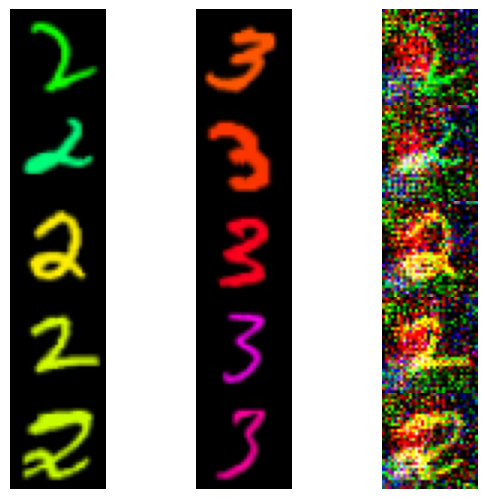

In [46]:
# pivotals_list shape (plot_n_samples, n_steps, (RGB image))
pivotals_list, _, _ = draw_linked_mapping(
    X_sampler,
    Y_sampler,
    SDEs,
    plot_n_samples=5,
)

In [47]:
print(f"{len(pivotals_list) = }")

len(pivotals_list) = 5


In [48]:
print(f"{len(pivotals_list[0]) = } {pivotals_list[0][0].shape = }")

len(pivotals_list[0]) = 8 pivotals_list[0][0].shape = torch.Size([1, 3, 32, 32])


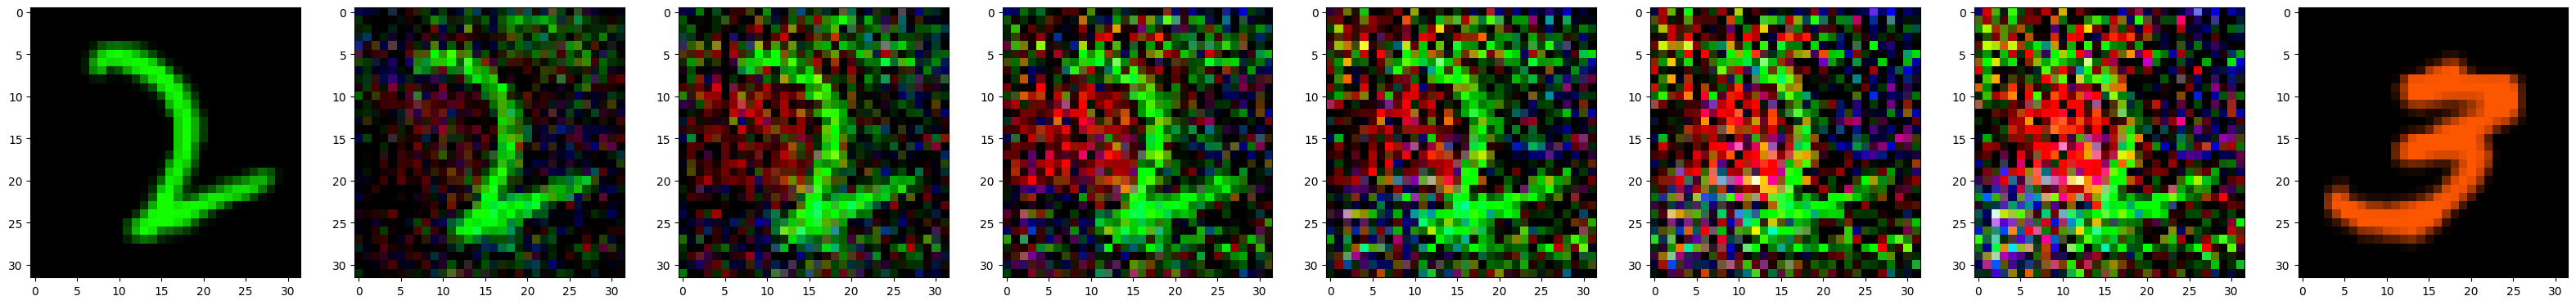

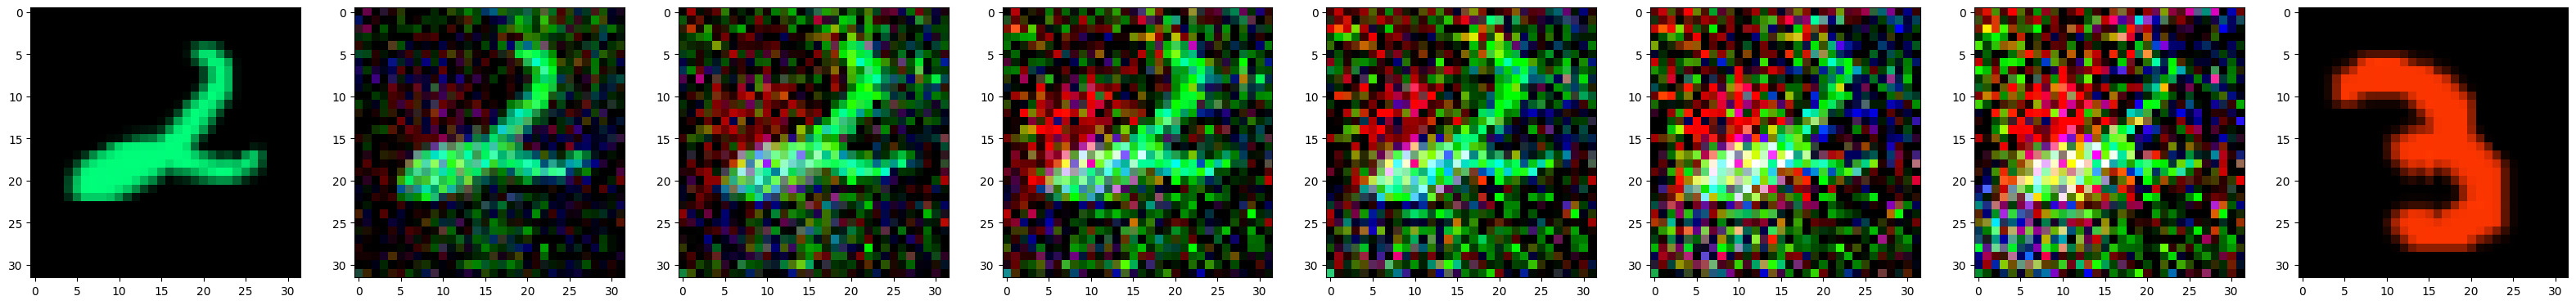

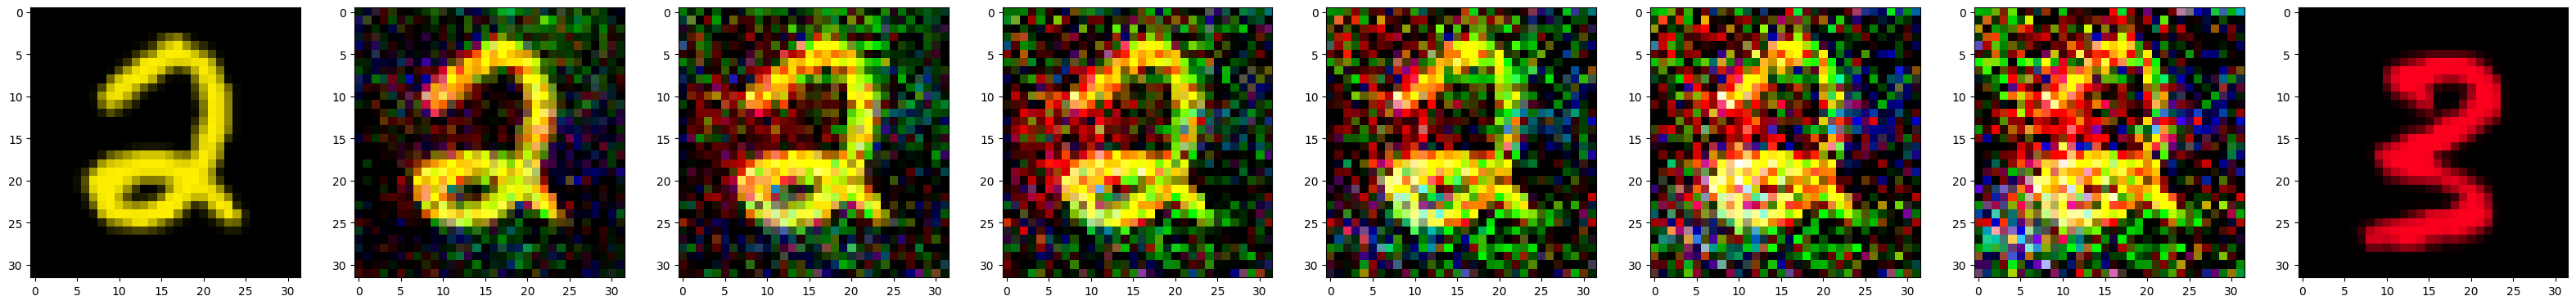

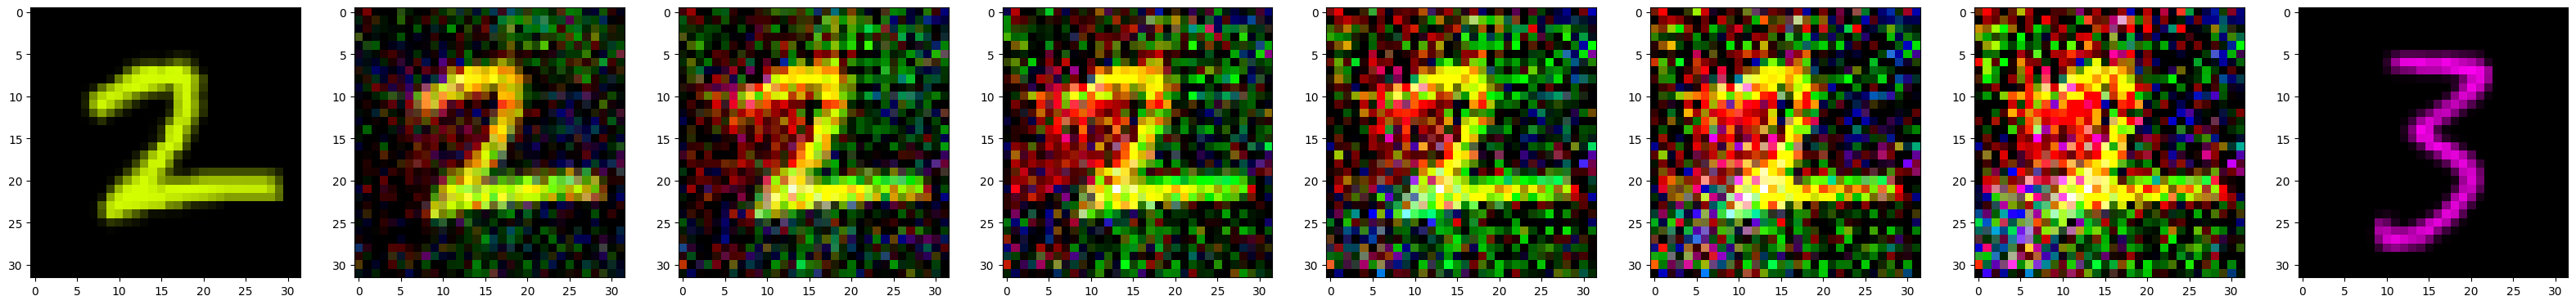

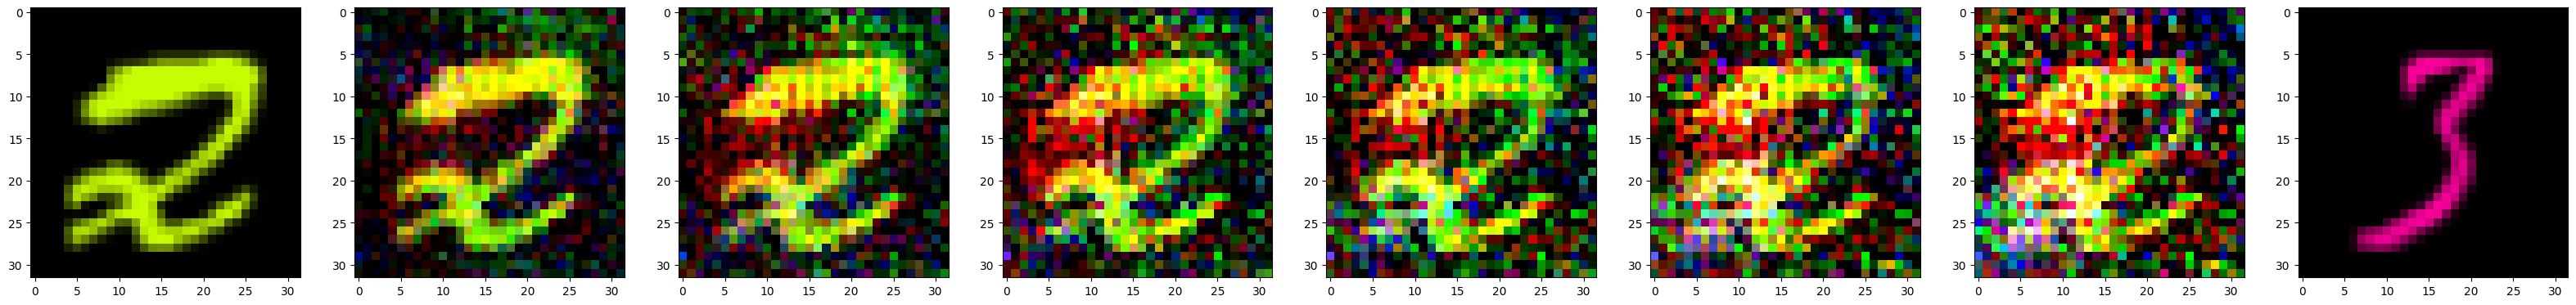

In [58]:
for pivotals in pivotals_list:
    fig, axes = plt.subplots(1, 8, figsize=(40, 5))
    axes = axes.flatten()
    for pivotal, ax in zip(pivotals, axes):
        img = torch.squeeze(pivotal).to("cpu")
        img = img.permute(1, 2, 0).mul(0.5).add(0.5).numpy().clip(0, 1)
        ax.imshow(img)